In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [20]:
image = cv2.imread("x.jpg")
#image = cv2.resize(image, (5, 5))
itensor = image.transpose(2, 0, 1)[None]  # 等同于image.transpose(2,0,1)[np.newaxis,:]
# 有点像zip(*data)
# data里每一组包含3个对象，unzip的时候把这三个对象分别解到三个数组里去
# 这里就是把三个像素值解到三个数组里去，其它维度不变
# itensor = np.array(list(zip(*image)))
# itensor = image.transpose(2,0,1)[np.newaxis,:]
itensor.shape

(1, 3, 324, 450)

In [21]:
def gaussian_kernel2d(size, sigma):
    
    s = 2 * sigma ** 2
    center = size // 2
    output = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            y = i - center
            x = j - center
            output[i, j] = np.exp(-(x ** 2 + y ** 2) / s)
    return output / np.sum(output)

In [27]:
#kernel = np.repeat(gaussian_kernel2d(3, 1)[None], 3, axis=0)
kernel = np.vstack([
    np.array(
    [
        [1, 0, -1], 
        [1, 0, -1], 
        [1, 0, -1]
    ])[None],
    np.array(
    [
        [1, 0, -1], 
        [1, 0, -1], 
        [1, 0, -1]
    ])[None],
    gaussian_kernel2d(3, 10)[None]
])
kernel.shape

(3, 3, 3)

In [28]:
_, kh, kw = kernel.shape
kh, kw

(3, 3)

In [29]:
n, c, h, w = itensor.shape
n, c, h, w

(1, 3, 324, 450)

* 计算输出维度的列数s = (image_width - kernel_width + 1) x (image_height - kernel_height + 1)

In [30]:
s = (w - kw + 1) * (h - kh + 1)
s

144256

In [31]:
column = np.zeros((kh * kw * c, s))
column.shape

(27, 144256)

In [32]:
col_kernel = kernel.reshape(1, -1)
col_kernel.shape

(1, 27)

* image2column

In [33]:
half_kx = kw // 2
half_ky = kh // 2
ksize = kw * kh
for ic in range(c):
    col_x = 0
    for iy in range(half_ky, h - half_ky):
        for ix in range(half_kx, w - half_kx):
            for iky in range(kh):
                for ikx in range(kw):
                    pixel_value = itensor[0, ic, iy - half_ky + iky, ix - half_kx + ikx]
                    col_y = ic * ksize + ikx + iky * kw
                    column[col_y, col_x] = pixel_value
            col_x += 1

* 卷积计算，GEMM方法

In [35]:
output = col_kernel @ column
output.shape

(1, 144256)

In [36]:
# 恢复变为图像维度
oim = output.reshape(h - kh + 1, -1)

# 归一化
oim = (oim - np.min(oim)) / (np.max(oim) - np.min(oim))
oim.shape

(322, 448)

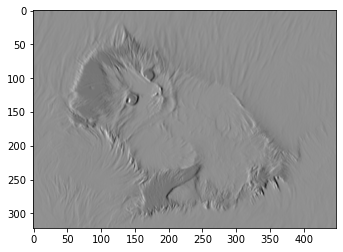

In [37]:
plt.imshow(oim, cmap="gray")

### 作业
1. 实现输入为2张3通道图，输出为2通道结果。kernel采用3x3第一组采用拉普拉斯核[1, 1, 1, 1, -8, 1, 1, 1, 1]，第二组采用梯度核[1, 0, -1, 1, 0, -1, 1, 0, -1]

In [109]:
image1 = cv2.imread("x.jpg")
image1 = cv2.resize(image1, (200, 160))
image1 = image1.transpose(2, 0, 1)[None]
image2 = cv2.imread("cv2.png")
image2 = cv2.resize(image2, (200, 160))
image2 = image2.transpose(2, 0, 1)[None]
# 使用image1和image2进行3x3卷积操作，得到3x3x2的输出

In [110]:
# tensor   1, 3, 5, 5
#   2, 3, 5, 5
# 带有batch的im2col，和多个输出（这里是2）
tensor = np.vstack([image1, image2])
tensor.shape

(2, 3, 160, 200)

In [111]:
image1.shape, image2.shape

((1, 3, 160, 200), (1, 3, 160, 200))

In [119]:
kernel = np.vstack([
    np.array(
    [
        [1, 1, 1], 
        [1, -8, 1], 
        [1, 1, 1]
    ])[None],
    np.array(
    [
        [1, 0, -1], 
        [1, 0, -1], 
        [1, 0, -1]
    ])[None],
    gaussian_kernel2d(3, 10)[None]
])
kernel.shape

(3, 3, 3)

In [1]:
def gemm_conv(tensor, kernel):
    _, kh, kw = kernel.shape
    n, c, h, w = tensor.shape
    s = (w - kw + 1) * (h - kh + 1)
    column = np.zeros((n, kh * kw * c, s))
    col_kernel = kernel.reshape(1, -1)
    half_kx = kw // 2
    half_ky = kh // 2
    ksize = kw * kh
    
    for m in range(n):
        for ic in range(c):
            col_x = 0
            for iy in range(half_ky, h - half_ky):
                for ix in range(half_kx, w - half_kx):
                    for iky in range(kh):
                        for ikx in range(kw):
                            pixel_value = tensor[m, ic, iy - half_ky + iky, ix - half_kx + ikx]
                            col_y = ic * ksize + ikx + iky * kw
                            column[m, col_y, col_x] = pixel_value
                    col_x += 1
    output = col_kernel @ column
    
    oim = output.reshape(n, h - kh + 1, -1)
    return oim
    result = []
    for m in oim:
        result.append((m - np.min(m)) / (np.max(m) - np.min(m)))
    return result

imgs = gemm_conv(tensor, kernel)
plt.subplots_adjust(left=.1, right=1.5, top=1, bottom=.1)
for i,m in enumerate(imgs):
    plt.subplot(1,2,i+1)
    plt.imshow(m, cmap='gray')

NameError: name 'tensor' is not defined

In [47]:
import pandas as pd

In [48]:
for i in range(3):
    pd.DataFrame(image1[0, i]).to_csv(f"image1_{i}.csv")
    
for i in range(3):
    pd.DataFrame(image2[0, i]).to_csv(f"image2_{i}.csv")

In [73]:
kernel = np.array([
    [
        [1, 1, 1, 1, -8, 1, 1, 1, 1],
        [1, 1, 1, 1, -8, 1, 1, 1, 1],
        [1, 1, 1, 1, -8, 1, 1, 1, 1]
    ],
    [
        [1, 0, -1, 1, 0, -1, 1, 0, -1],
        [1, 0, -1, 1, 0, -1, 1, 0, -1],
        [1, 0, -1, 1, 0, -1, 1, 0, -1]
    ]
])
kernel = kernel.reshape(6, 3, 3)
kernel.shape

(6, 3, 3)

In [74]:
for i in range(6):
    pd.DataFrame(kernel[i]).to_csv(f"kernel_{i}.csv")
